## Summarizing results

We are trying a lot of different things. Let's log the attempts to share with others

The scripts here will NOT work. We are just keeping track of what we are trying and what is different.

### Modules

In [32]:
import pandas as pd
import numpy as np
import glob,os
import IPython.display as dp

### Parameter recovery : v002

The code for BHM was the same throughout v000-v002. The differences came from the vlues of the dataset:
- v000: I accidentally selected a single beta value to simulate
- v001: The values for gamma were too high in this version and the last
- v002: version of parameters that reflects distribution from MLE estimates below



### BHM code for v002

Here the priors are defined with the following parameters

```
def estimate_bhm(subj_id=[],design_df=[],choices=[],type='single'):

    sure_p = design_df['crdm_sure_p'].values
    lott_p = design_df['crdm_lott_p'].values
    sure_amt = design_df['crdm_sure_amt'].values
    lott_amt = design_df['crdm_lott_amt'].values
    ambig = design_df['crdm_amb_lev'].values

    # We will fit a model for each subject
    with pm.Model() as model_simple:

        # Hyperparameters for alpha, beta
        mu_alpha_hyper = pm.Normal('mu_alpha_hyper',mu=-0.635,sigma=0.05)
        sd_alpha_hyper = pm.Normal('sd_alpha_hyper',mu=0.418,sigma=0.01)

        mu_beta_hyper = pm.Normal('mu_beta_hyper',mu=0.254,sigma=0.05)
        sd_beta_hyper = pm.Normal('sd_beta_hyper',mu=0.575,sigma=0.01)
        
        # mu_gamma_hyper = pm.Normal('mu_gamma_hyper',mu=3.011,sigma=0.05)
        sd_gamma_hyper = pm.Normal('sd_gamma_hyper',mu=2.046,sigma=0.01)

        alpha = pm.LogNormal('alpha',mu=mu_alpha_hyper, sigma=sd_alpha_hyper,shape=np.size(np.unique(subj_id)))
        beta = pm.Normal('beta',mu=mu_beta_hyper,sigma=sd_beta_hyper,shape=np.size(np.unique(subj_id)))
        gamma = pm.HalfNormal('gamma',sigma=sd_gamma_hyper,shape=np.size(np.unique(subj_id)))
        
        prob = pm.Deterministic('prob', 1 / (1 + pm.math.exp(-gamma[subj_id] * 
                                                             ((lott_amt**alpha[subj_id])*(lott_p-beta[subj_id]*ambig/2)
                                                              - (sure_amt**alpha[subj_id])*sure_p)))) 
        
        y_1 = pm.Bernoulli('y_1',p=prob,observed=choices)

        # trace_prior = pm.sample(100, tune=20, cores=2,target_accept=0.95,progressbar=False)
        trace_prior = pm.sample(10000, tune=1000, cores=5,target_accept=0.99,progressbar=False)

    # This is how you get a nice array. Note that this returns a pandas DataFrame, not a numpy array. Indexing is totally different.
    summary= az.summary(trace_prior,round_to=10)
    if type=='single':
        alpha_hat = summary['mean'].loc['alpha[{}]'.format(0)]
        beta_hat = summary['mean'].loc['beta[{}]'.format(0)]
        gamma_hat = summary['mean'].loc['gamma[{}]'.format(0)]
    elif type=='aggregate':
        alpha_hat = [summary['mean'].loc['alpha[{}]'.format(x)] for x in set(subj_id)]
        beta_hat = [summary['mean'].loc['beta[{}]'.format(x)] for x in set(subj_id)]
        gamma_hat = [summary['mean'].loc['gamma[{}]'.format(x)] for x in set(subj_id)]
    return alpha_hat,beta_hat,gamma_hat
```

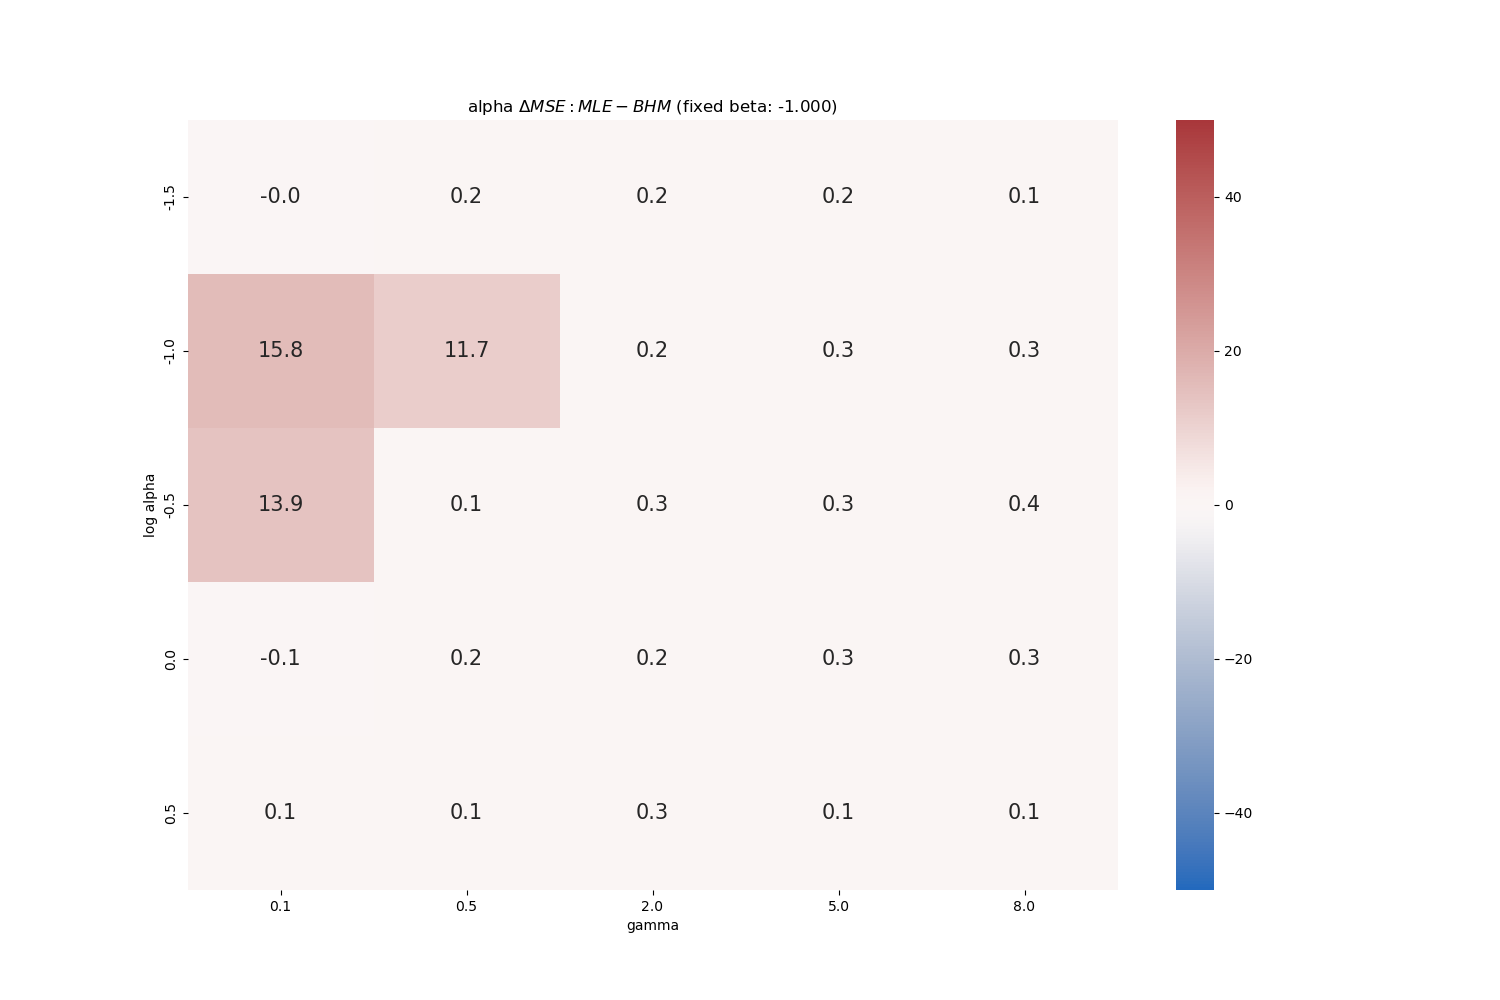

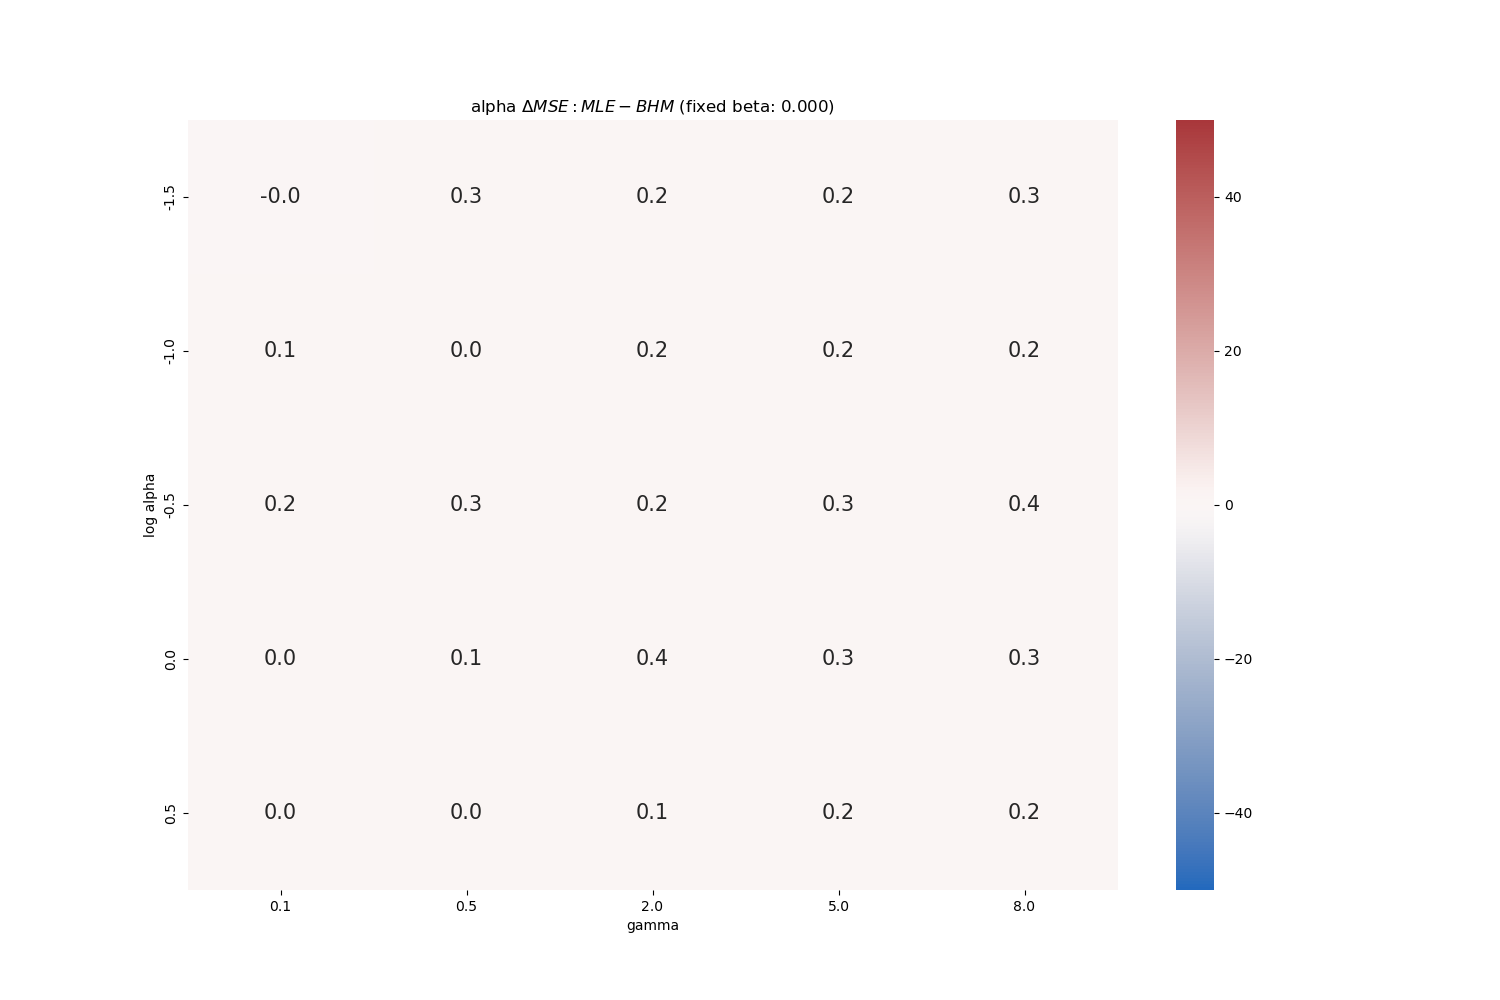

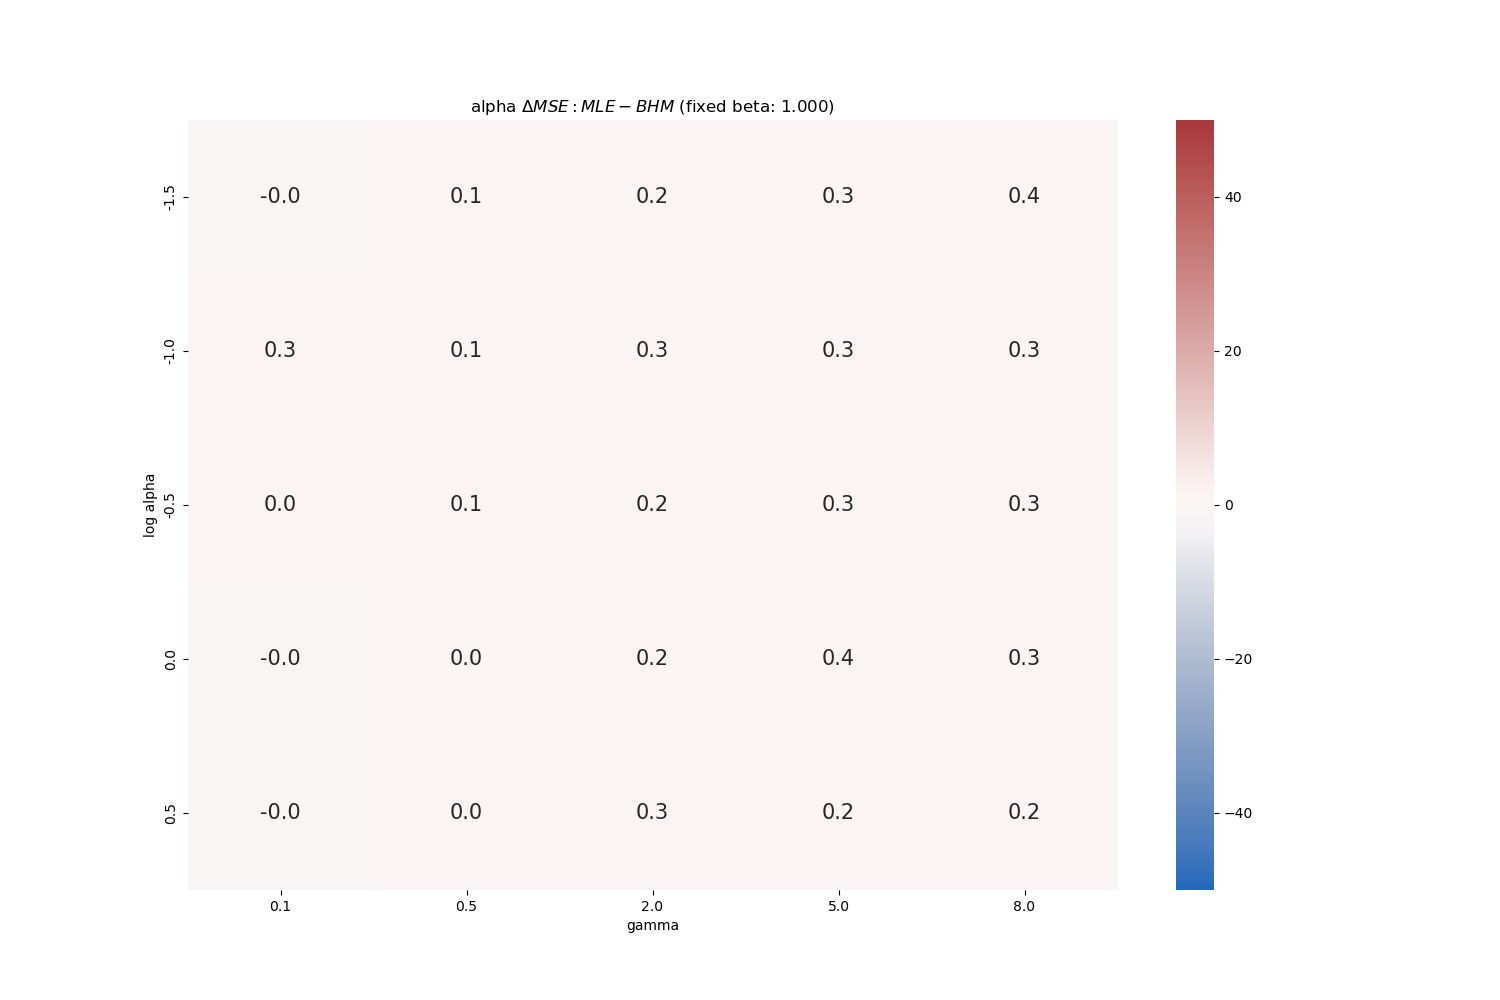

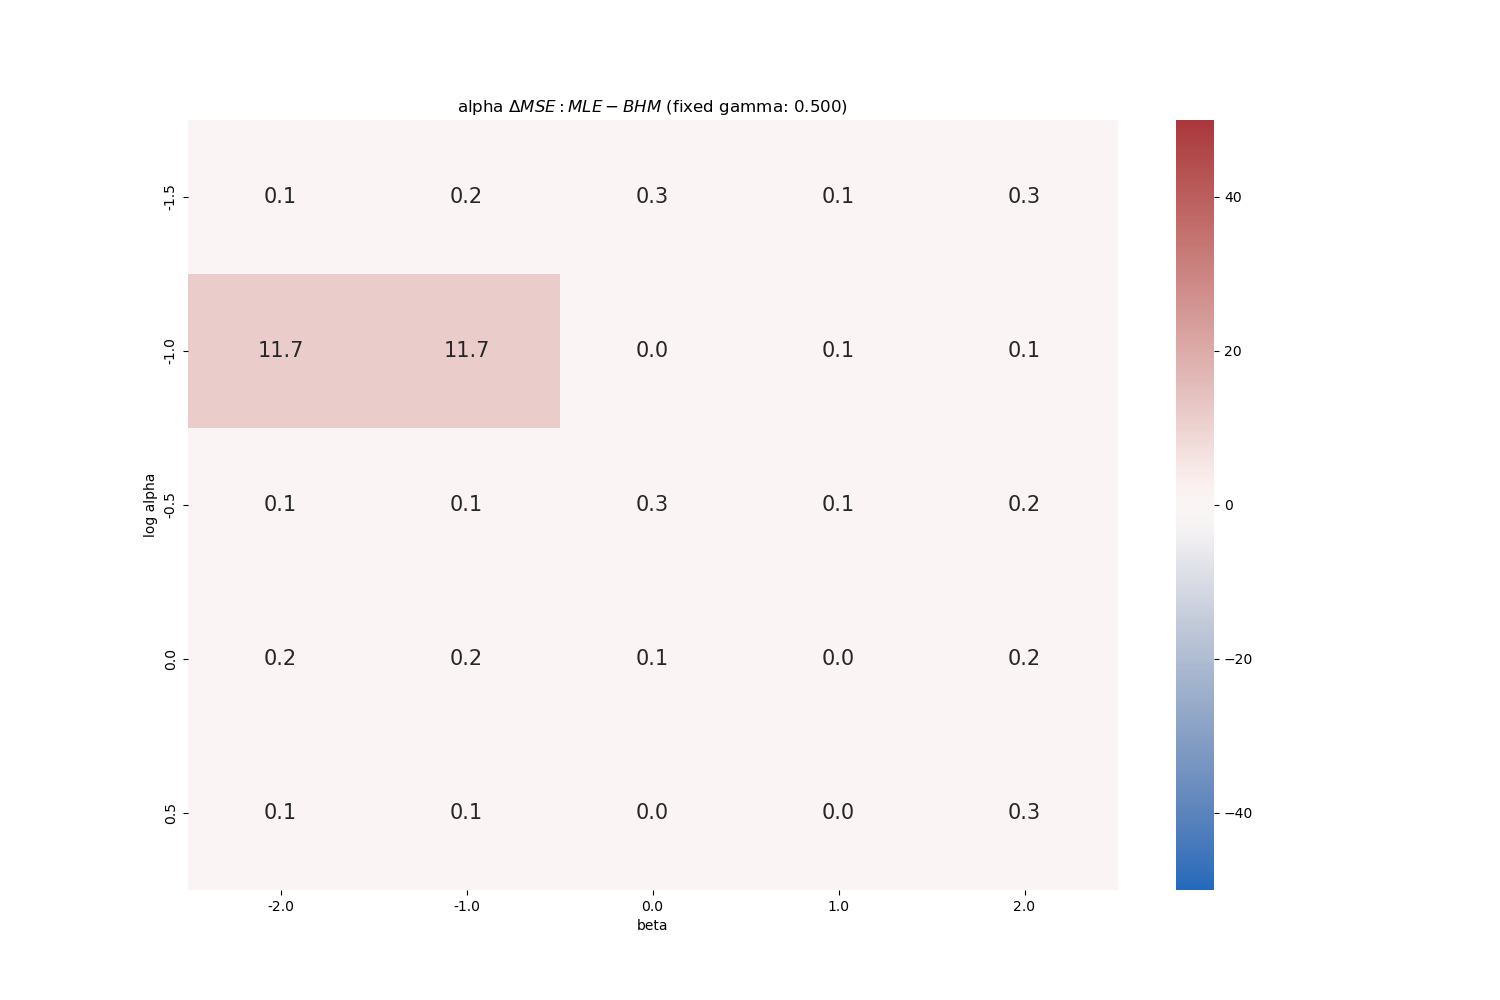

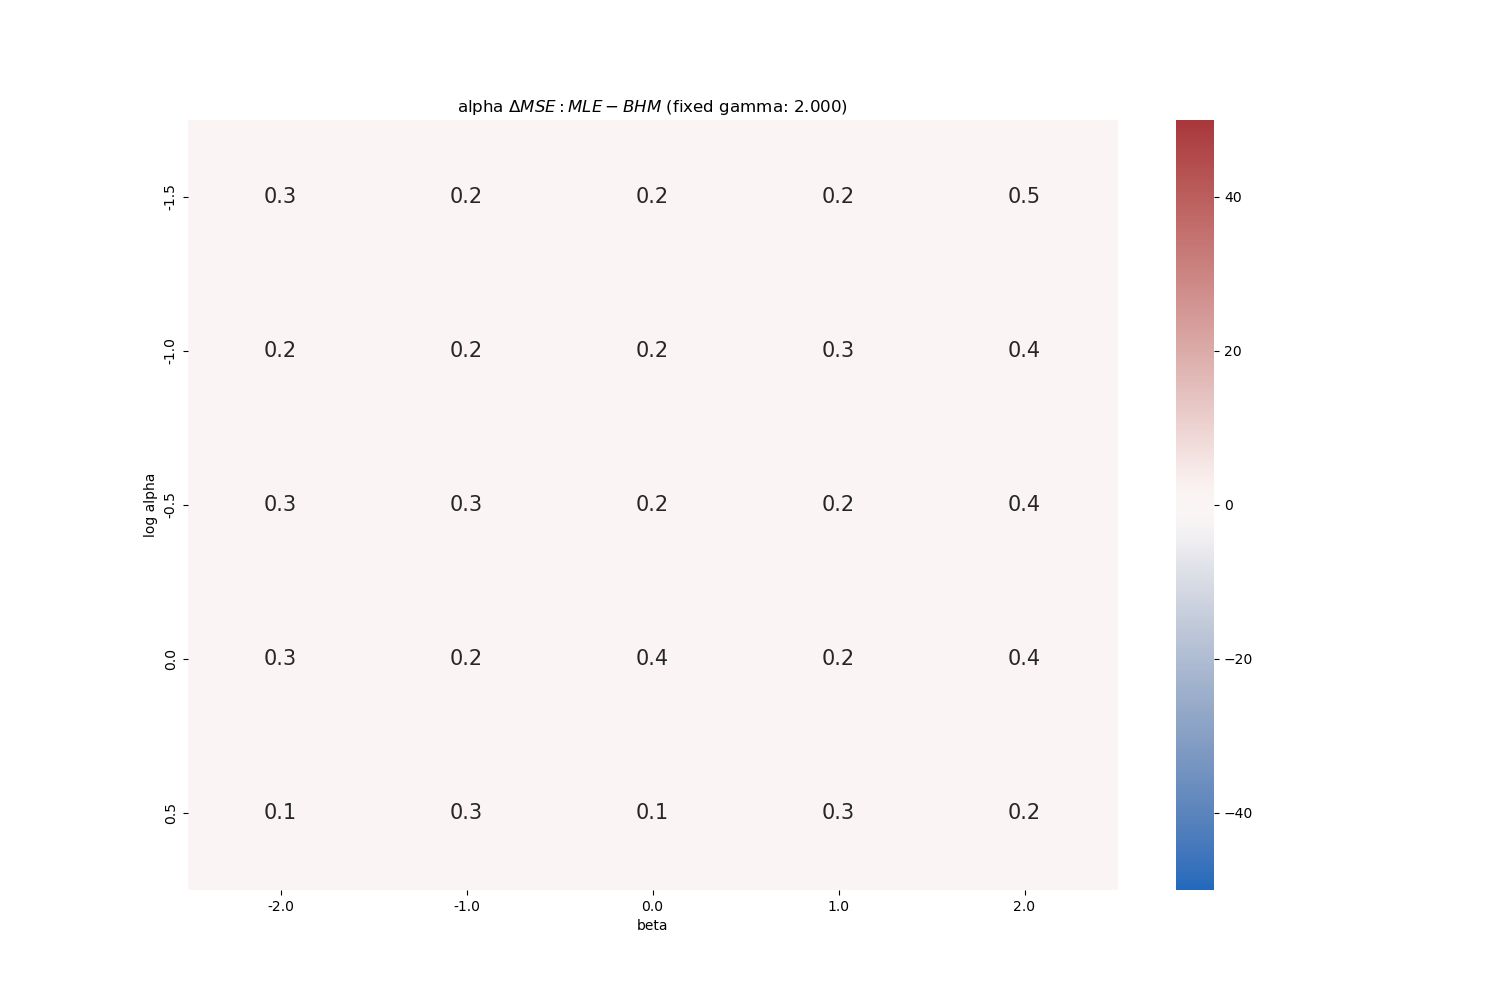

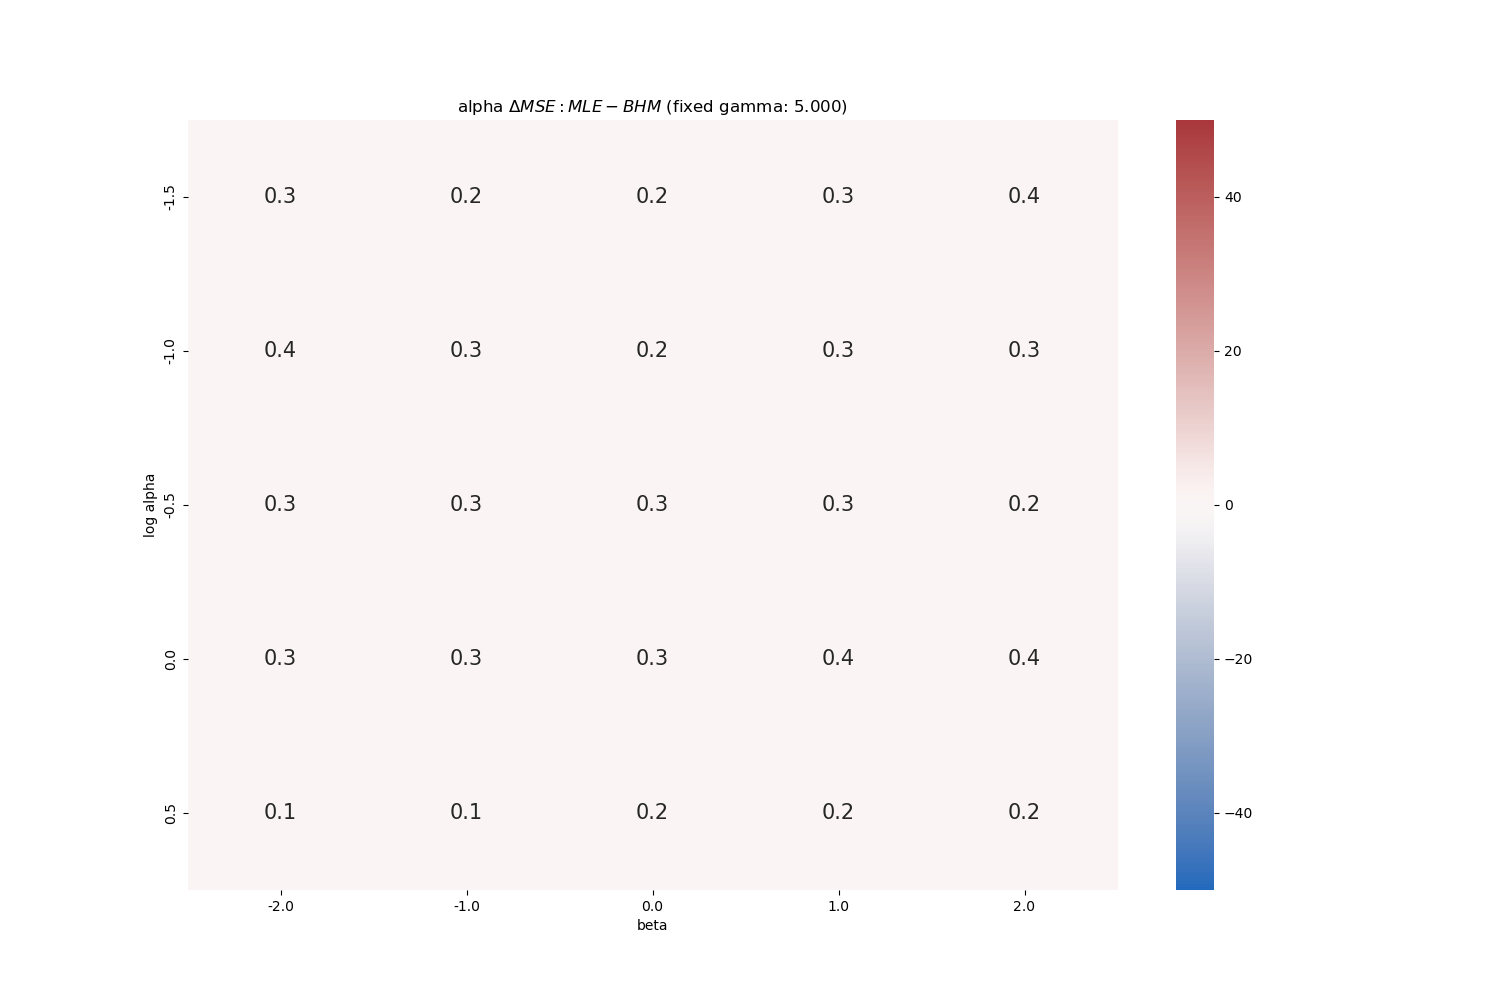

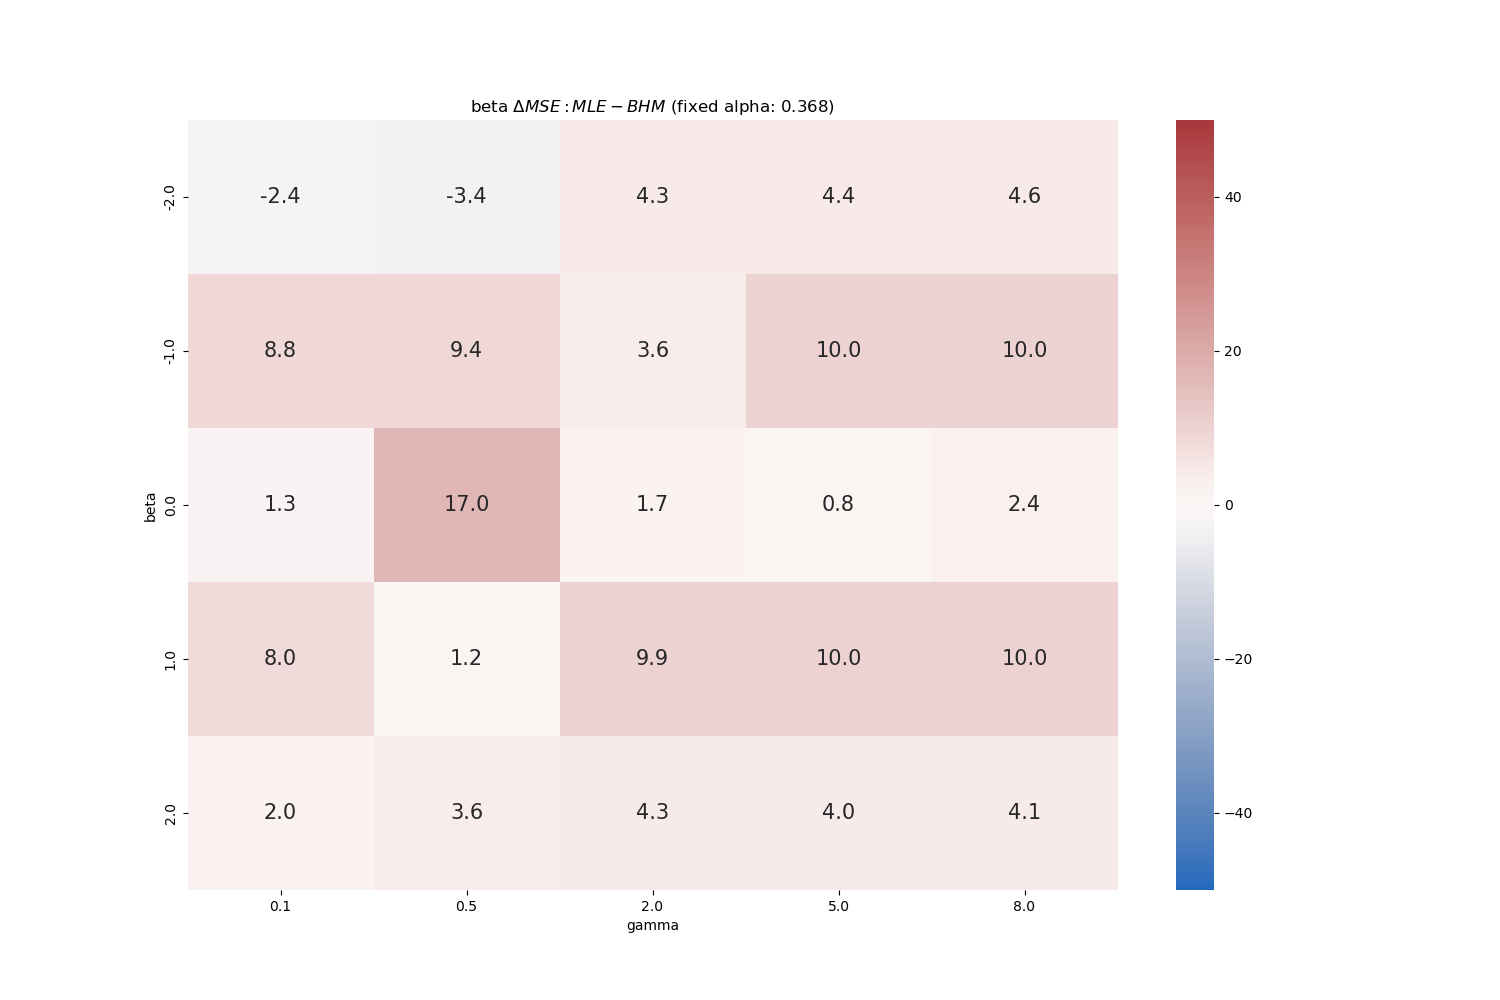

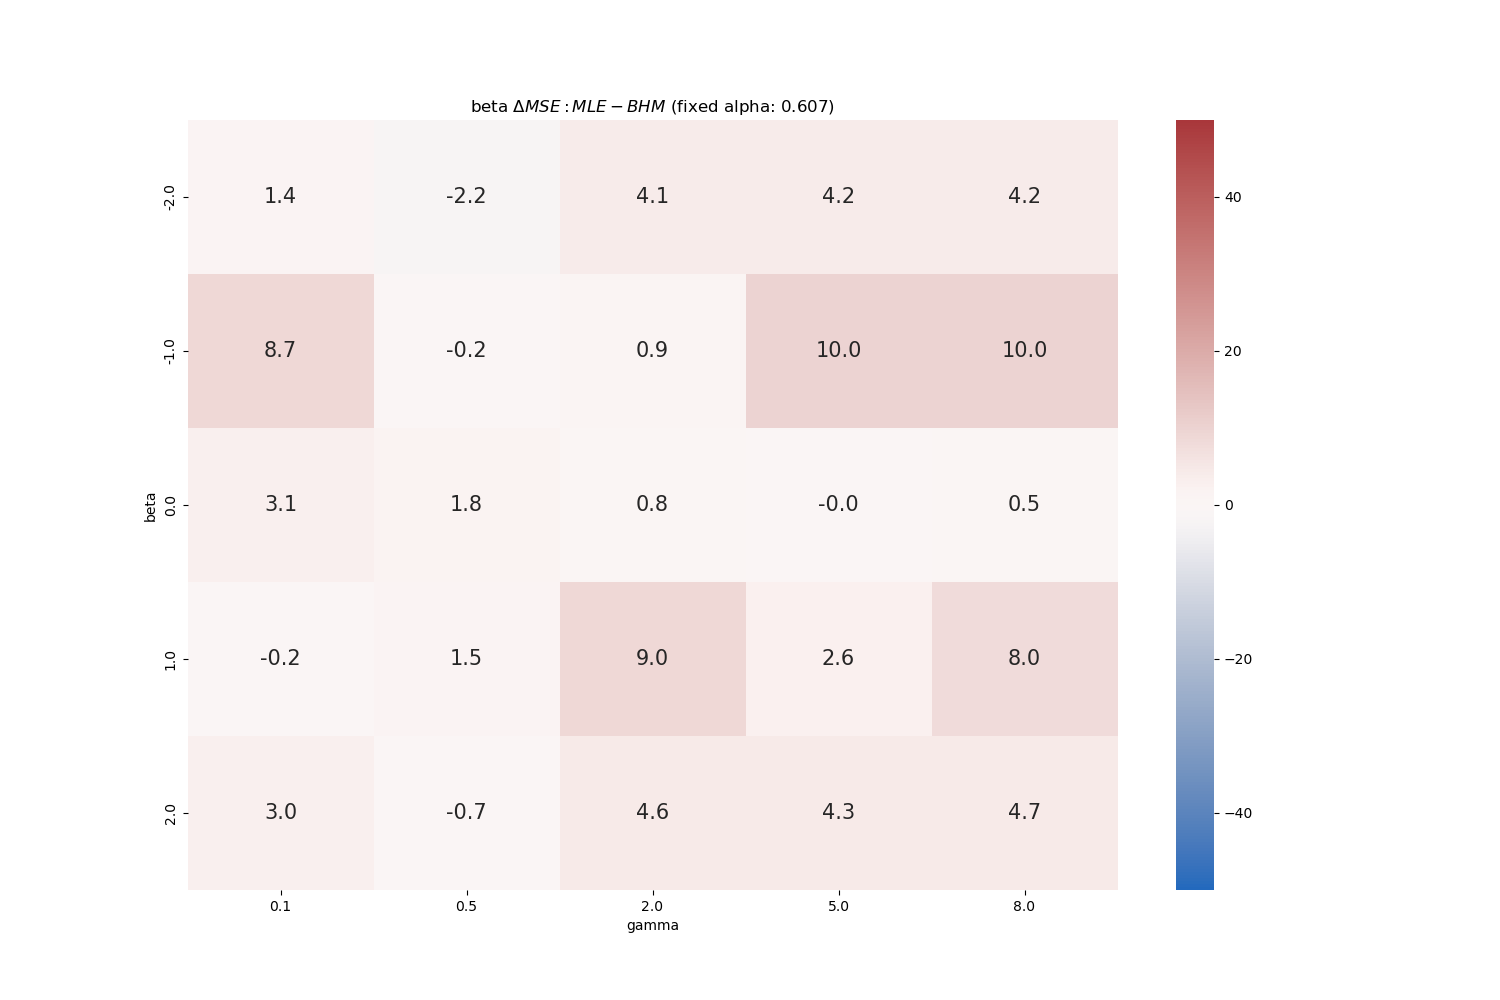

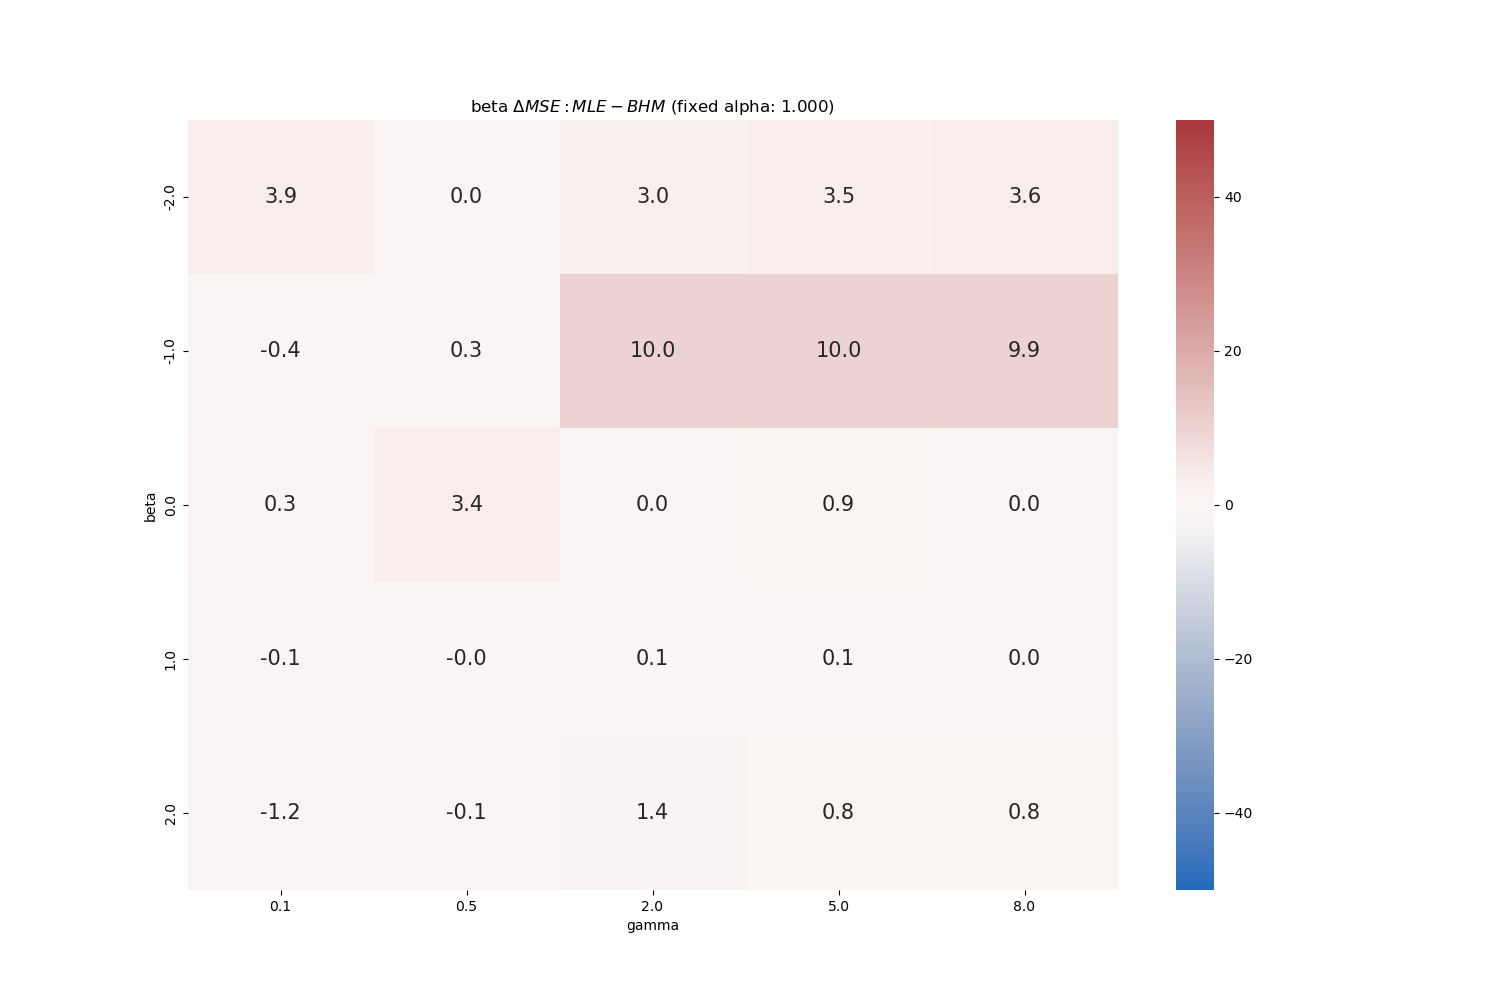

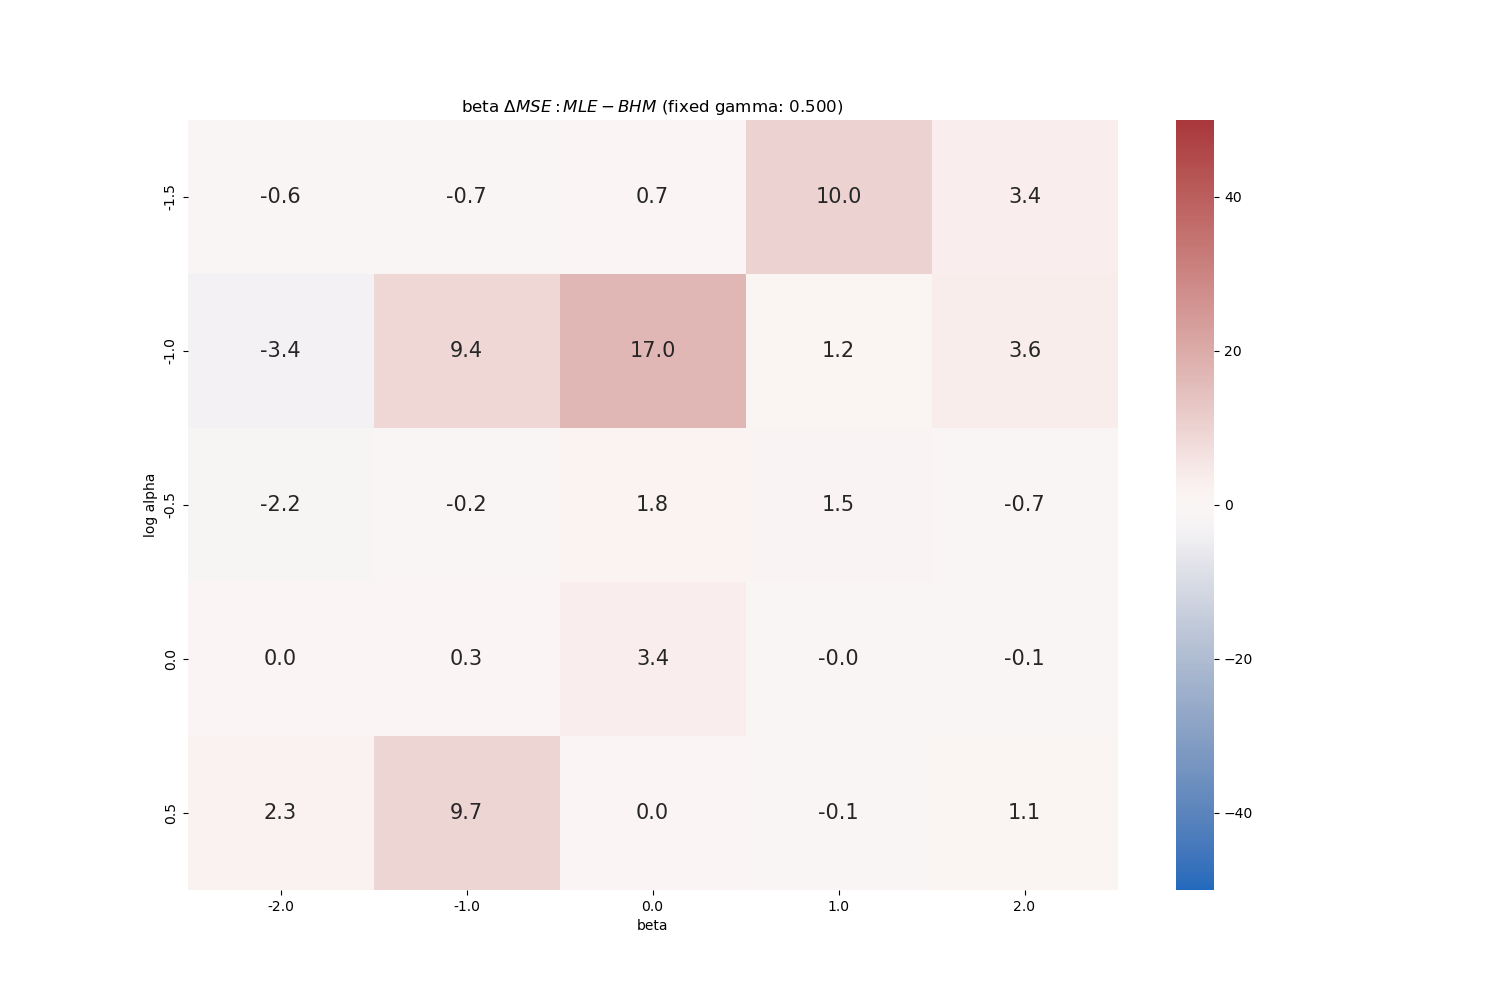

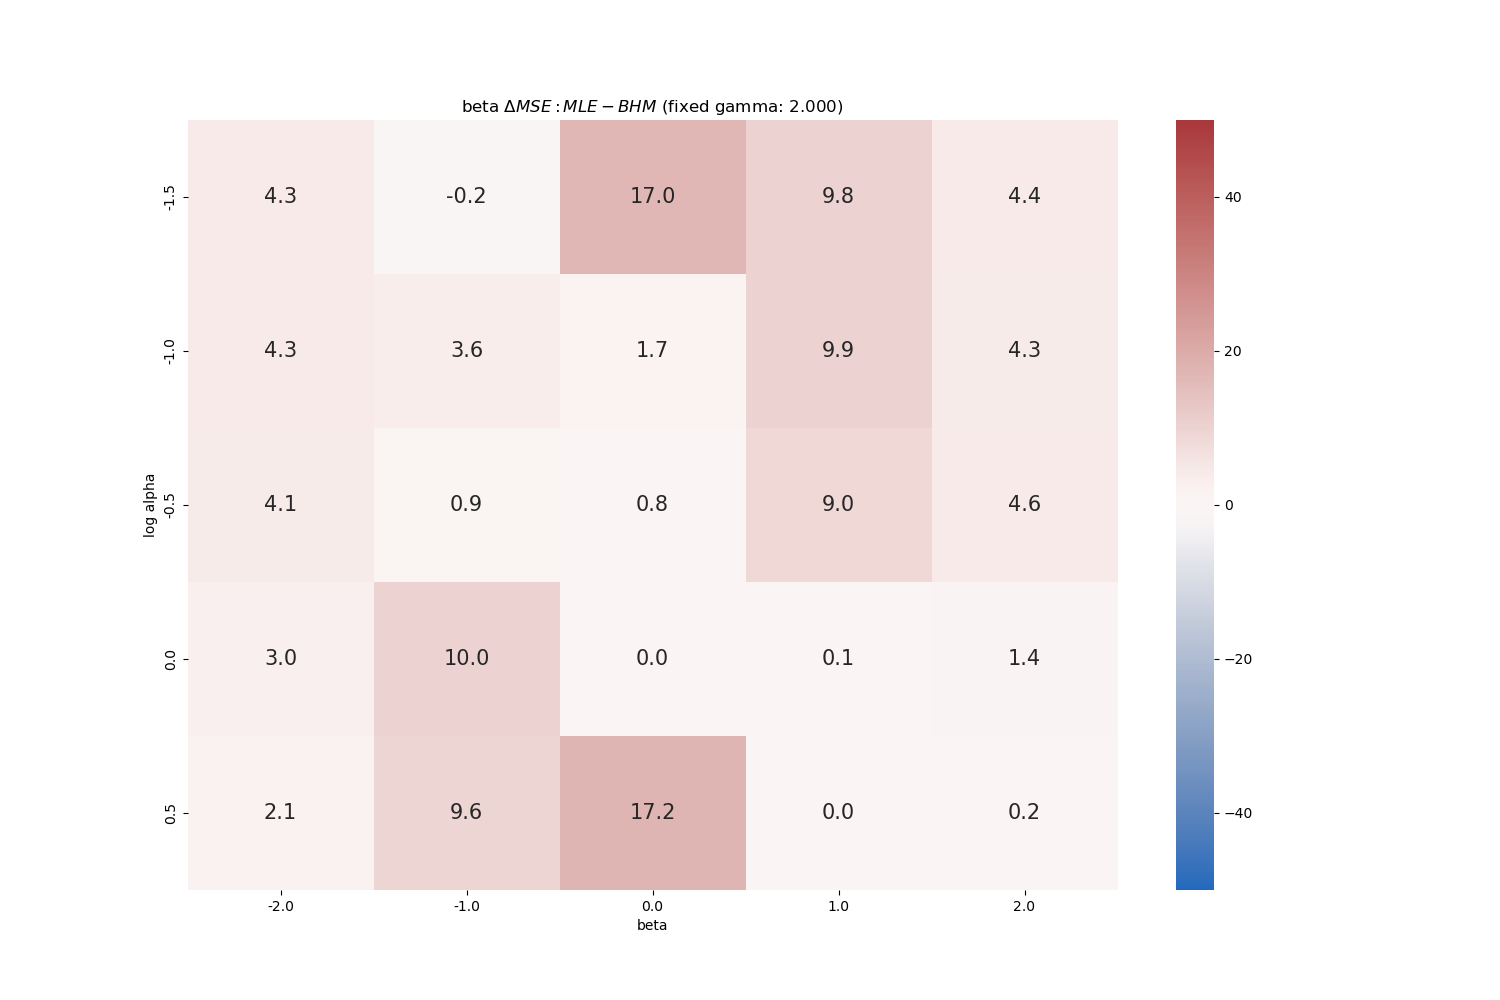

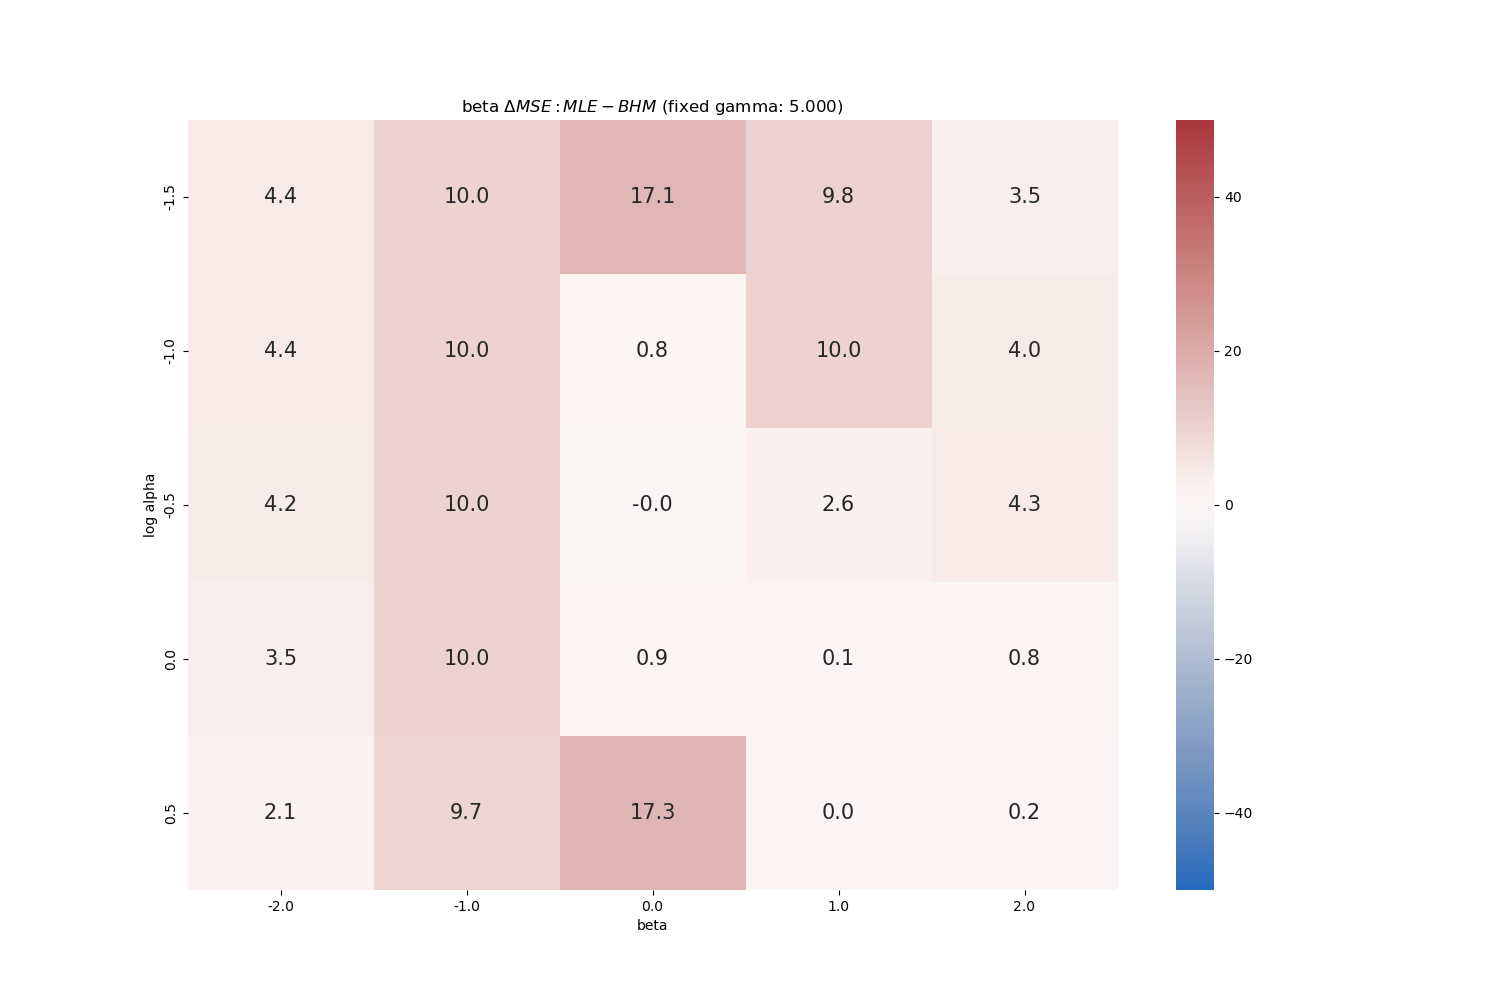

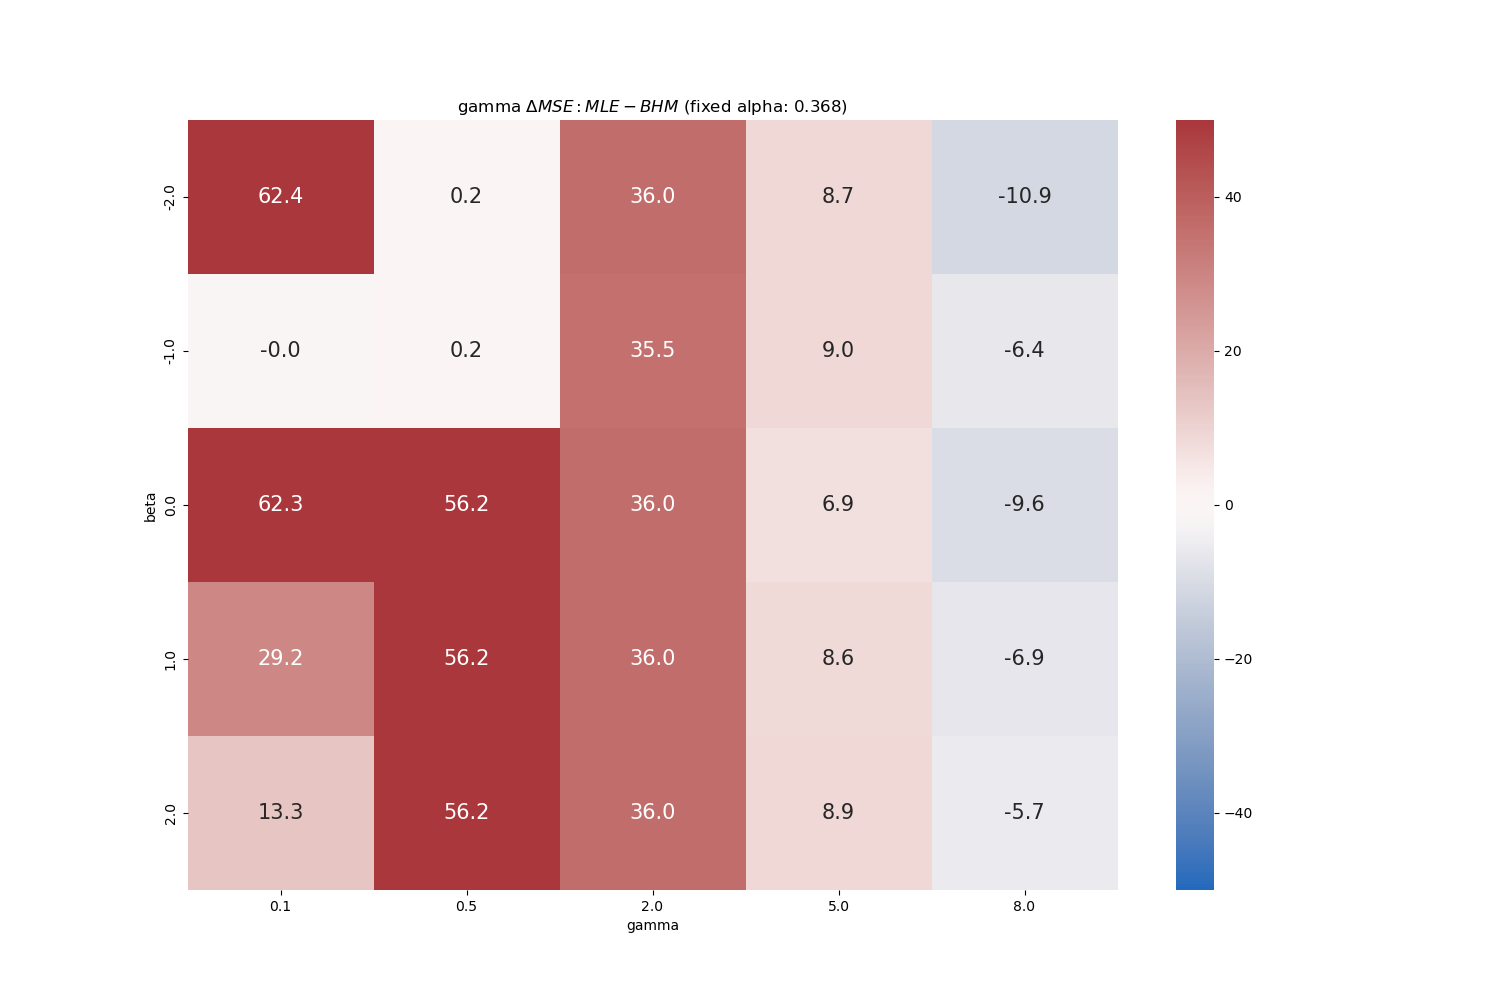

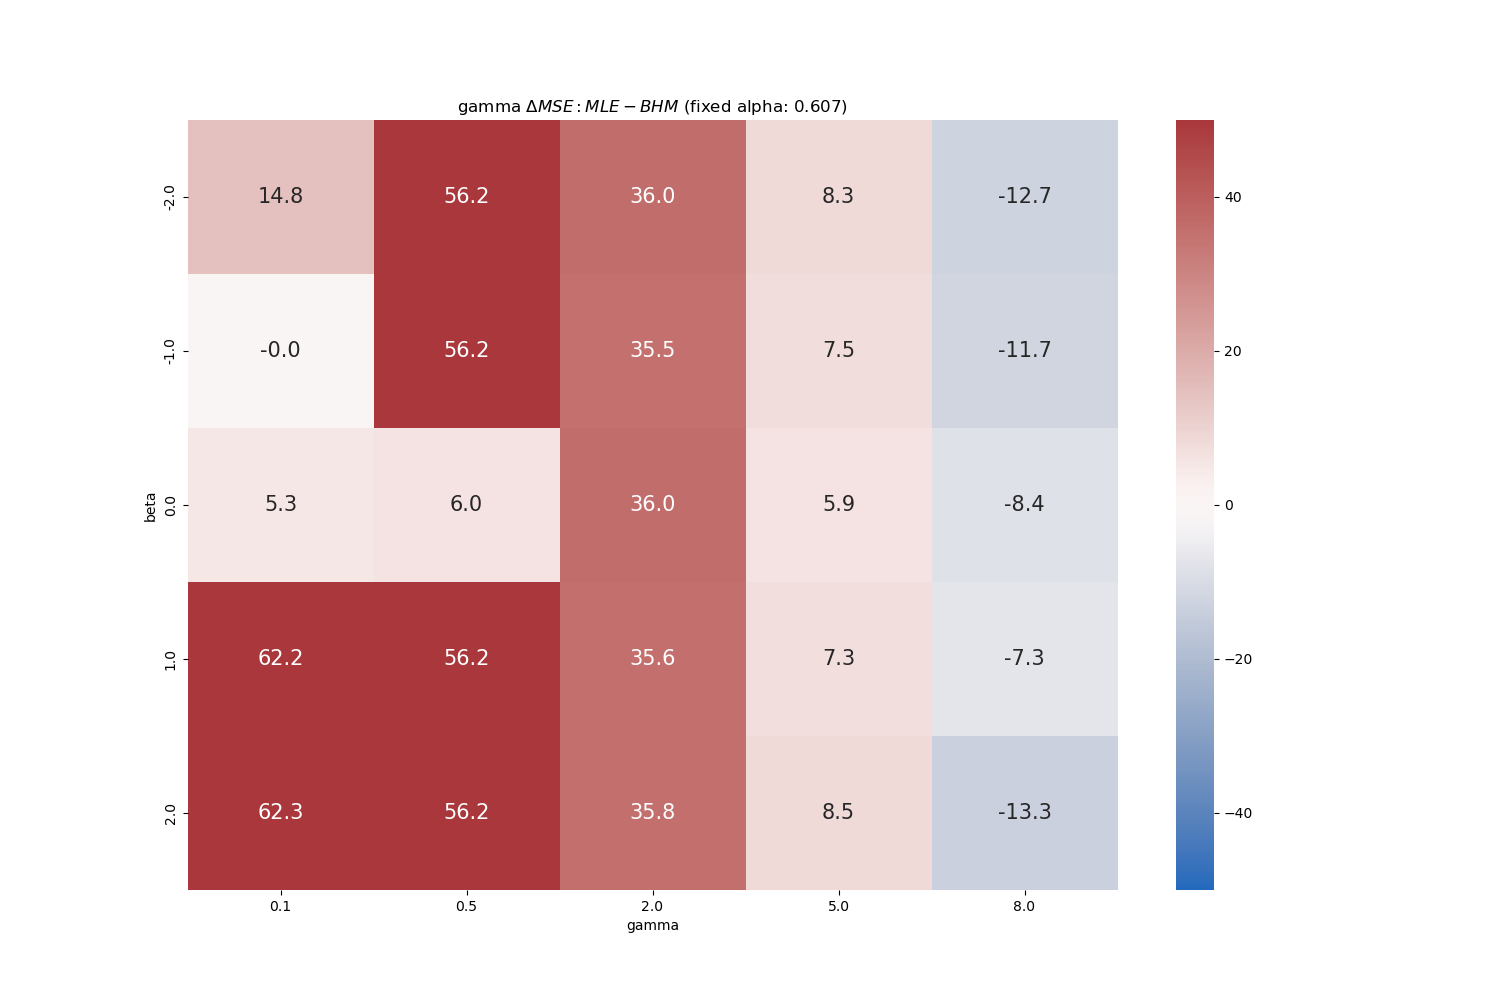

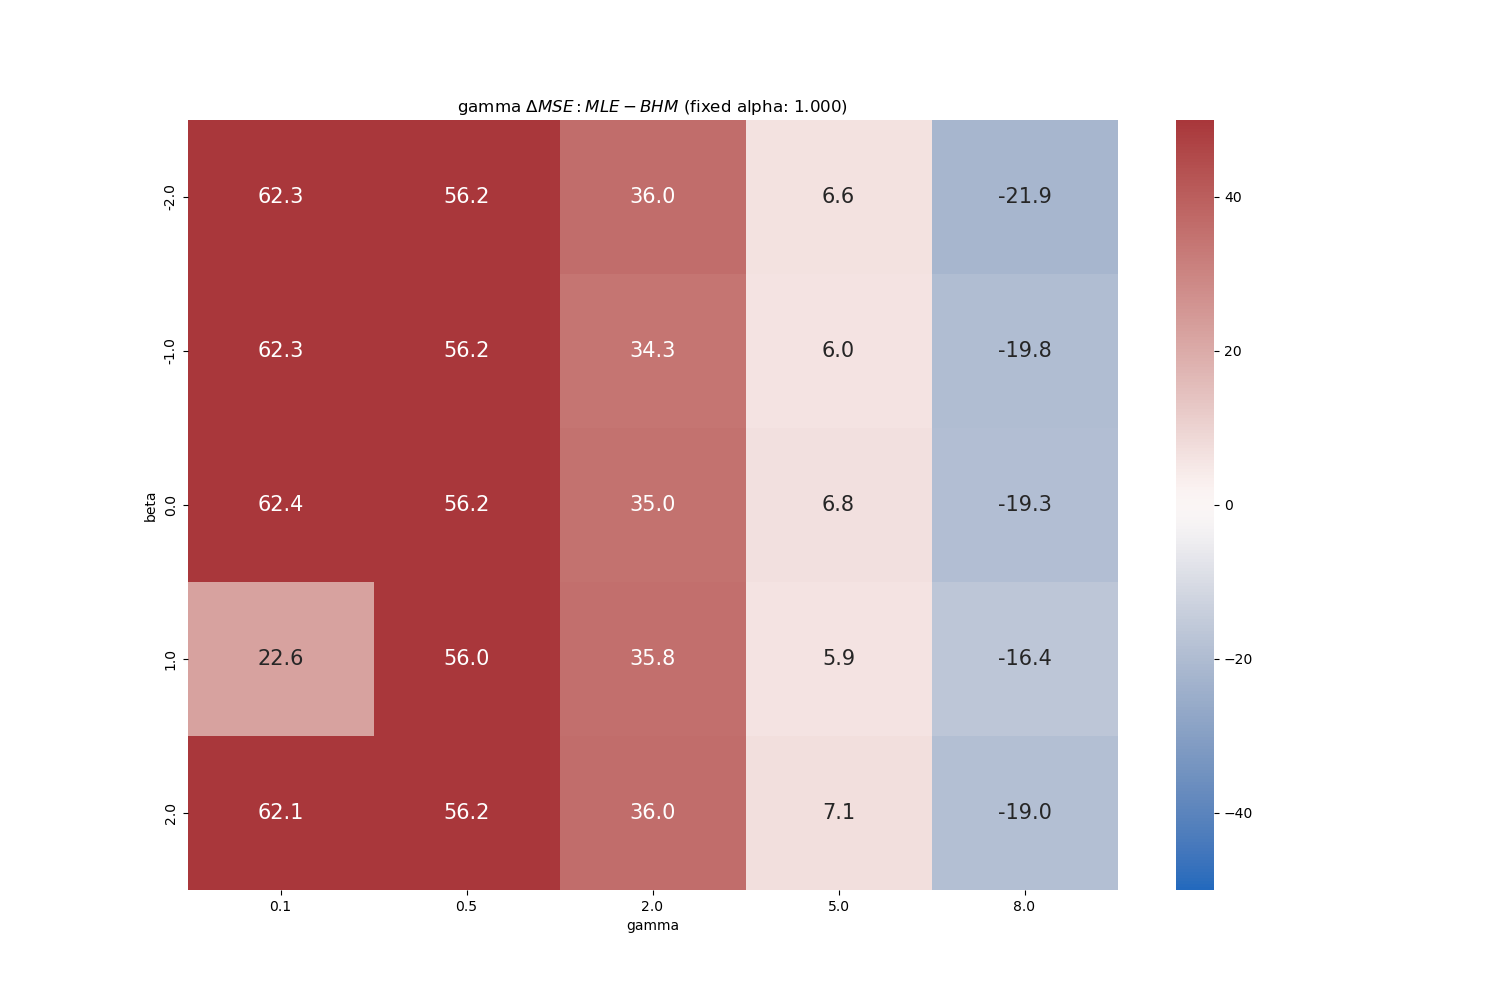

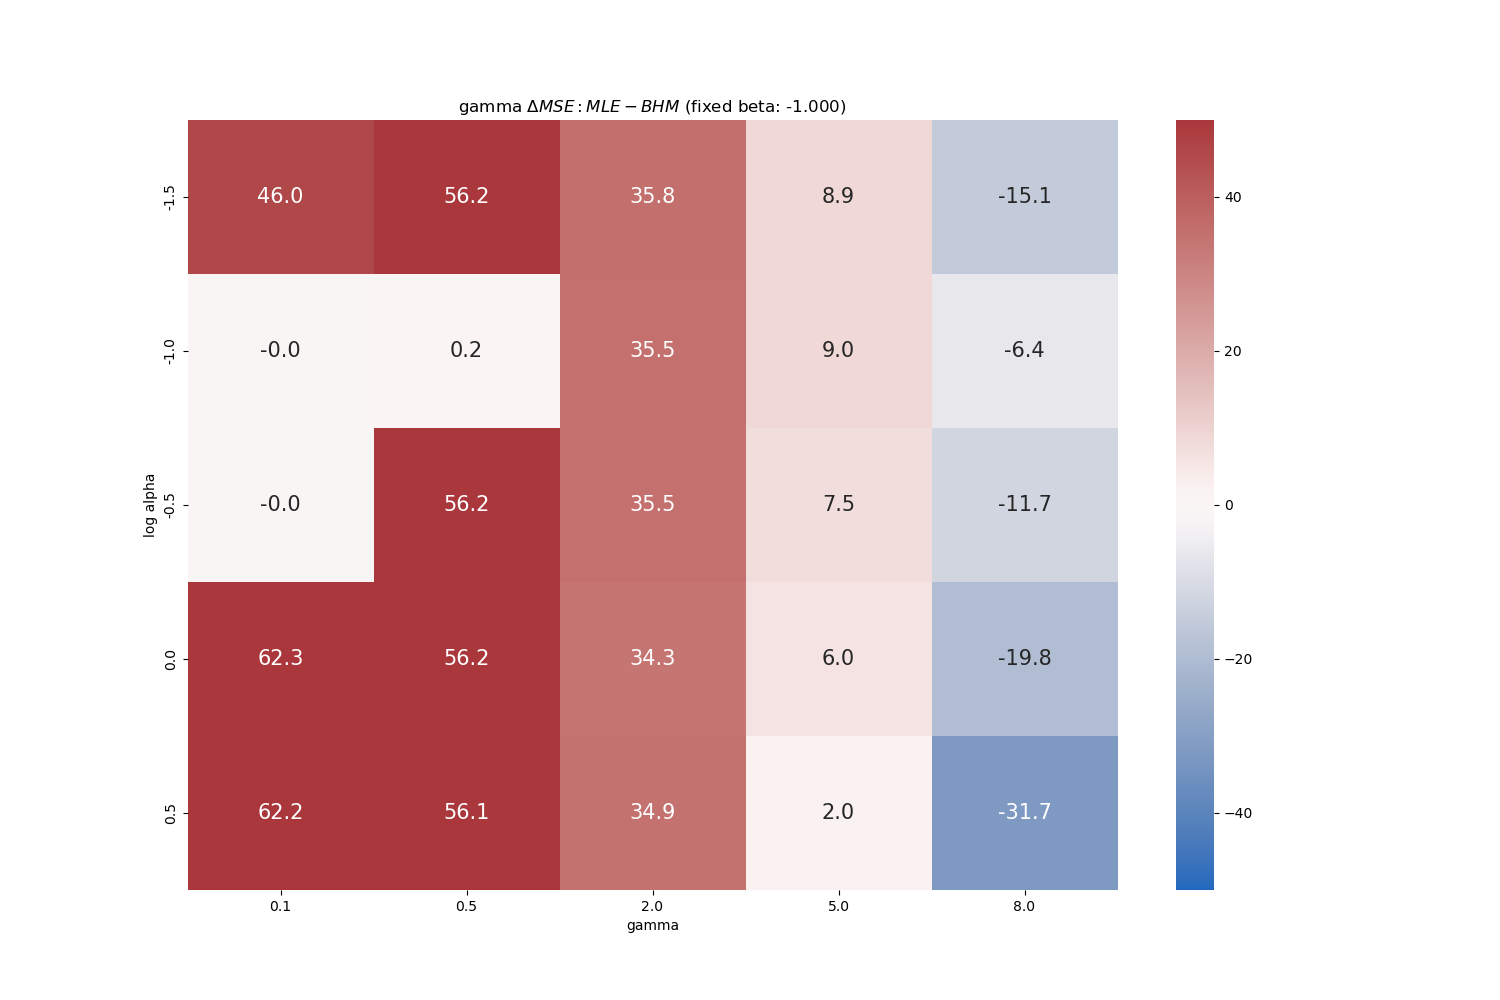

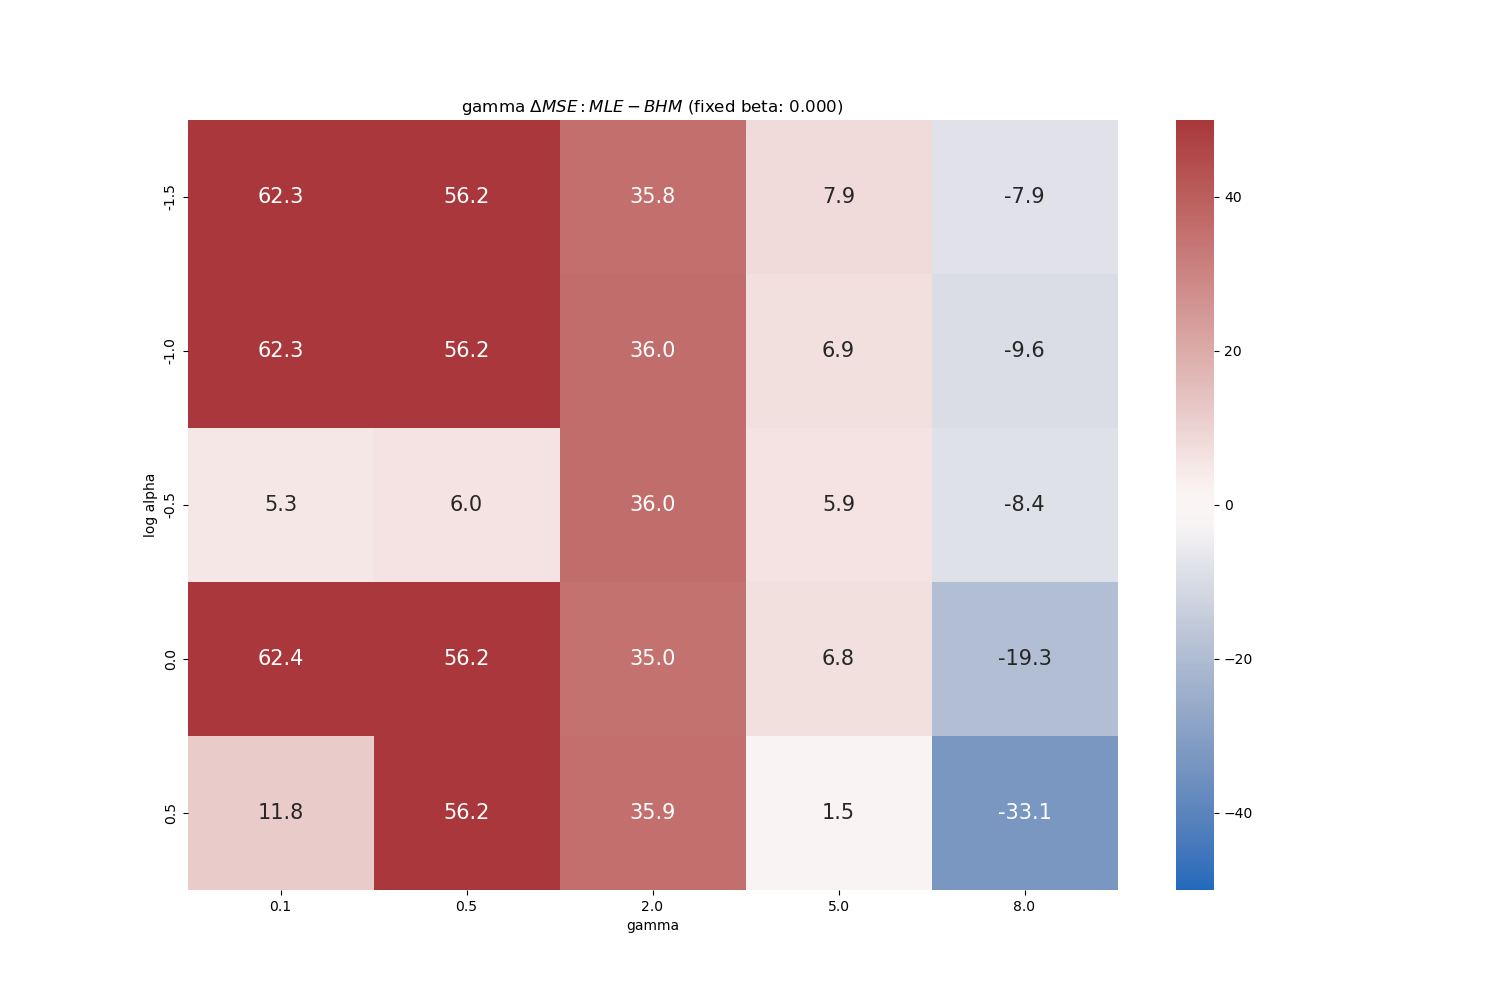

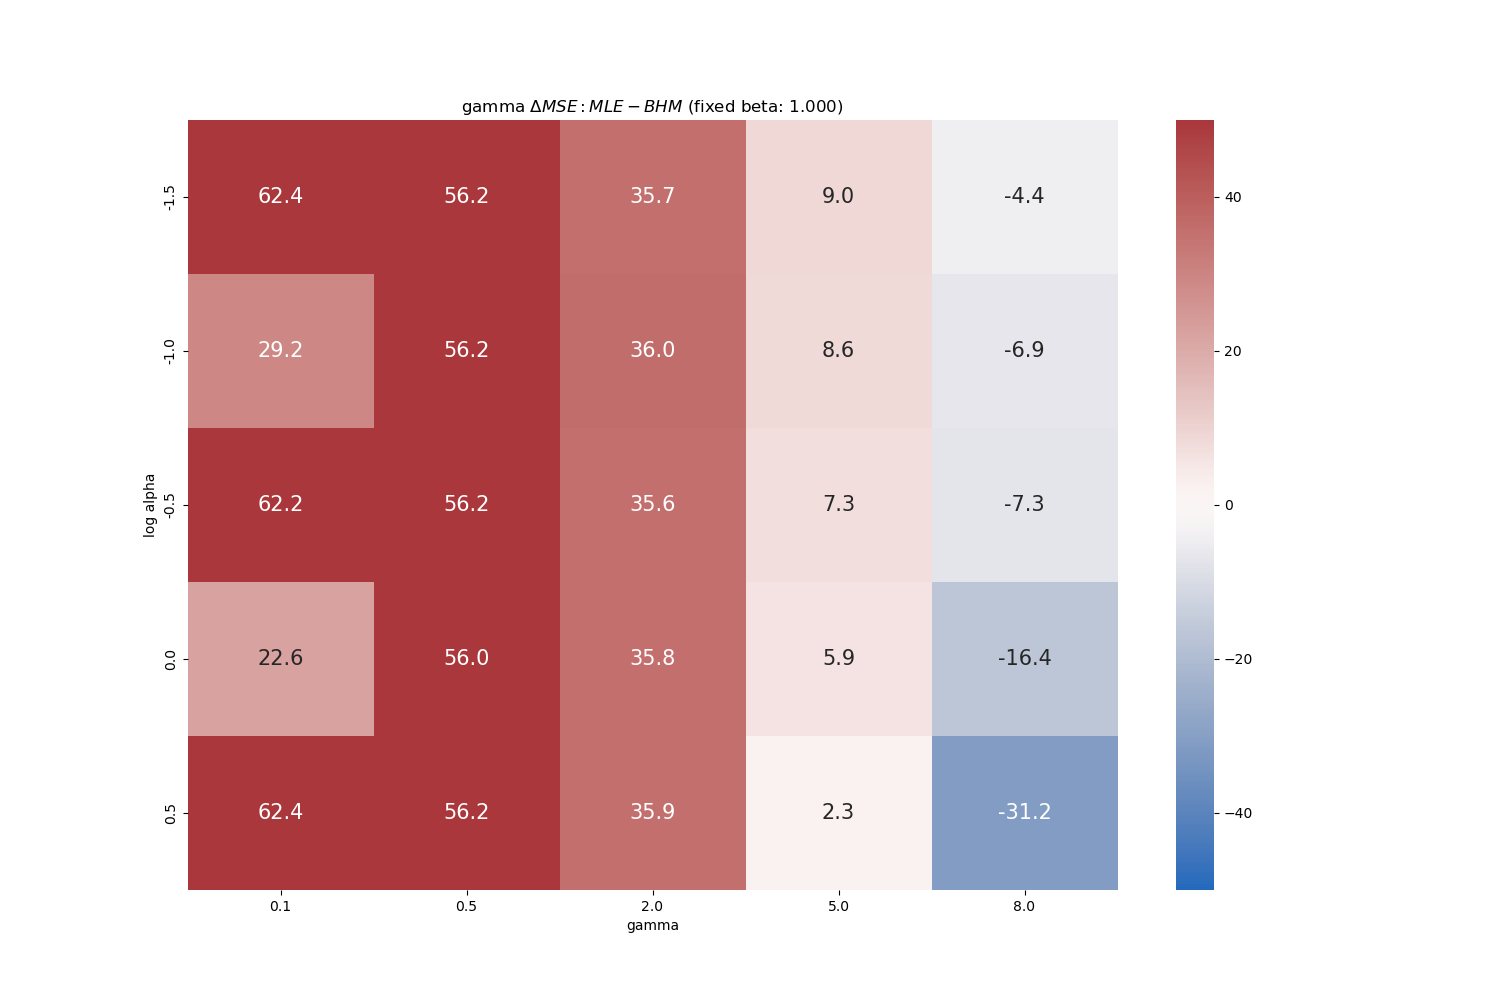

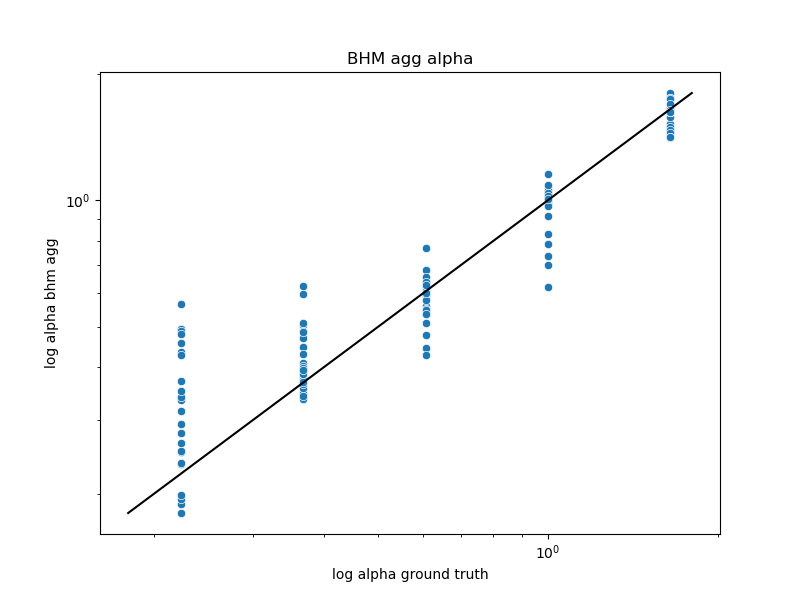

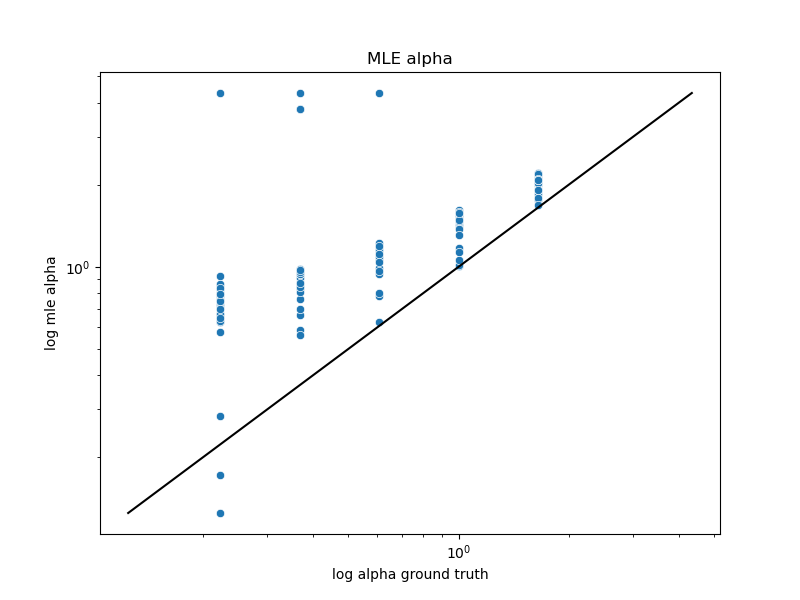

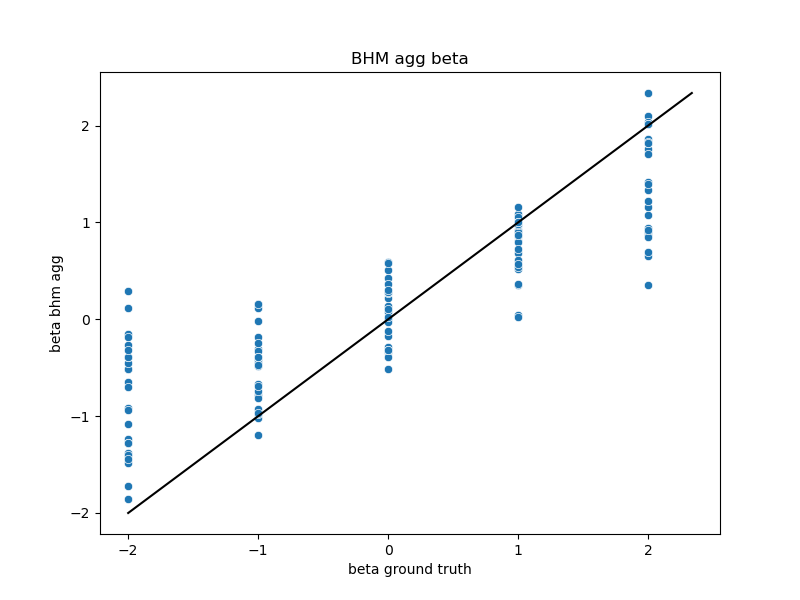

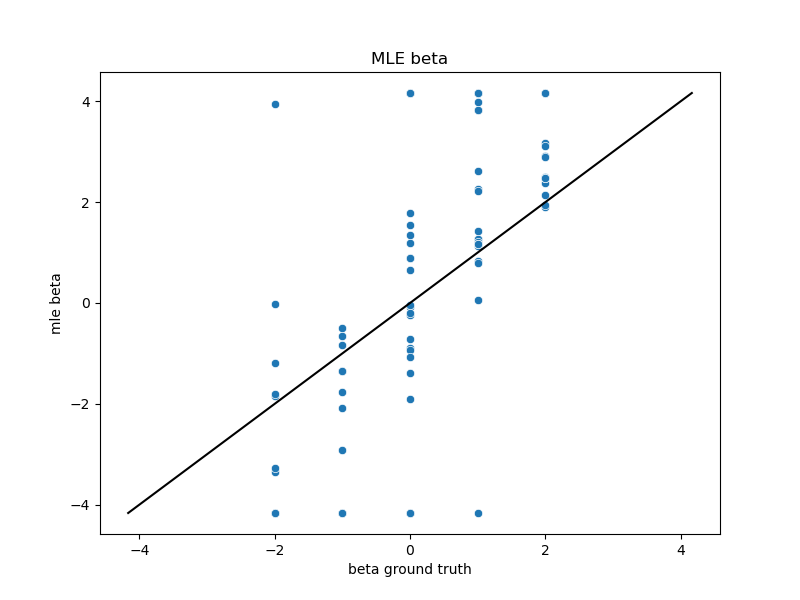

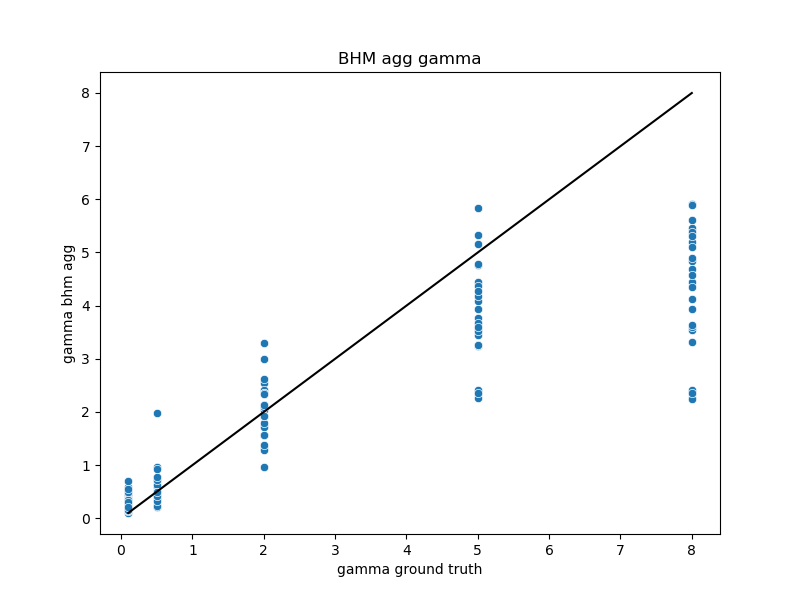

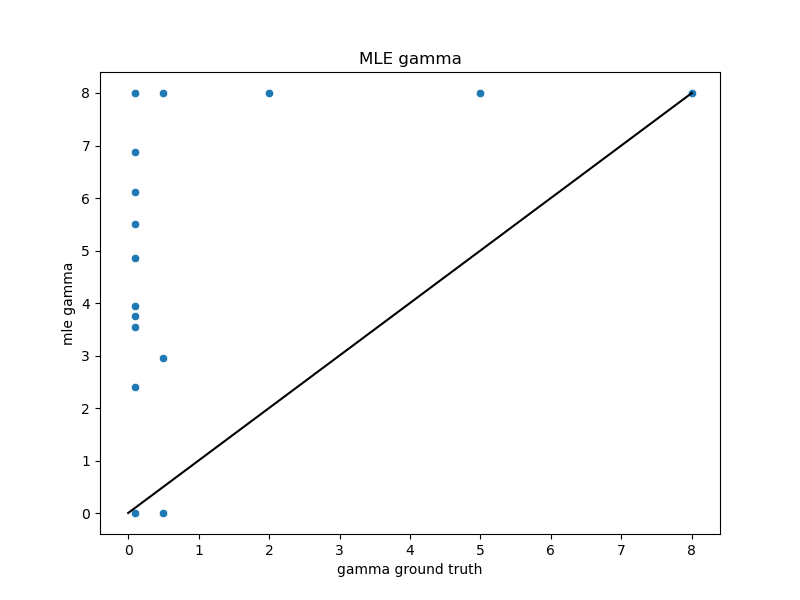

In [33]:
plots = ['mse_diff','scatter']
for p in plots:
    file_names = sorted(glob.glob(os.path.join('simul/img/v002/{}/*.png'.format(p))))
    # collect all .png files in working dir

    # create list of image objects
    images = []
    for ea in file_names:
        images.append(dp.Image(filename=ea, format='png'))

    # display all images
    for ea in images:
        dp.display_png(ea)

### Alpha and beta distribution

We start with the distribution of these parameters based on the MLE of the IDM dataset. Alpha and beta both seem log normal. The range for $\log(\alpha)$ is $[-2.00,0.50]$ and for $\log(\beta)$ is $[-4,1.5]$. Gamma seems to be uniform between $[0,8]$

<img src="img/mturk_all_CRDM_alpha_beta_scatter.png" width="400">
<img src="img/mturk_all_CRDM_alpha_gamma_scatter.png" width="400">



In [34]:
split_CRDM = '/Volumes/UCDN/datasets/IDM/utility/split_CRDM_analysis.csv'
df = pd.read_csv(split_CRDM)

col = 'alpha'
print('log {}'.format(col))
parm = np.log(df[col])
min,max = np.min(parm),np.max(parm)
print('(min,max) : ({0:0.3f},{1:0.3f})'.format(min,max))
# remove edge effects to compute distributiuon statistics
parm = parm[(parm>min)&(parm<max)]
print('(mean,std) : ({0:0.3f},{1:0.3f})'.format(np.mean(parm),np.std(parm)))

col = 'beta'
print(col)
parm = df[col]
min,max = np.min(parm),np.max(parm)
print('(min,max) : ({0:0.3f},{1:0.3f})'.format(min,max))
# remove edge effects to compute distributiuon statistics
parm = parm[(parm>min)&(parm<max)]
print('(mean,std) : ({0:0.3f},{1:0.3f})'.format(np.mean(parm),np.std(parm)))

col = 'gamma'
print(col)
parm = df[col]
min,max = np.min(parm),np.max(parm)
print('(min,max) : ({0:0.3f},{1:0.3f})'.format(min,max))
# remove edge effects to compute distributiuon statistics
parm = parm[(parm>min)&(parm<max)]
print('(mean,std) : ({0:0.3f},{1:0.3f})'.format(np.mean(parm),np.std(parm)))



log alpha
(min,max) : (-2.079,0.619)
(mean,std) : (-0.635,0.418)
beta
(min,max) : (-4.167,4.167)
(mean,std) : (0.254,0.575)
gamma
(min,max) : (0.009,8.000)
(mean,std) : (3.011,2.046)


In [35]:
alpha_bounds = 'simul/alpha_estimates.csv'
df = pd.read_csv(alpha_bounds,index_col=0).reset_index(drop=True)
df

,alpha,log_alpha,crdm_sure_amt,crdm_sure_p,crdm_lott_amt,crdm_lott_p,crdm_amb_lev
0,0.124939,-2.079932e+00,5,1.0,50,0.75,0.0
1,0.138346,-1.977999e+00,5,1.0,40,0.75,0.0
2,0.207519,-1.572533e+00,5,1.0,20,0.75,0.0
3,0.301030,-1.200545e+00,5,1.0,50,0.50,0.0
4,0.333333,-1.098612e+00,5,1.0,40,0.50,0.0
5,0.420216,-8.669854e-01,5,1.0,50,0.38,0.0
6,0.465310,-7.650523e-01,5,1.0,40,0.38,0.0
7,0.500000,-6.931471e-01,5,1.0,20,0.50,0.0
8,0.602060,-5.073981e-01,5,1.0,50,0.25,0.0
9,0.612085,-4.908842e-01,5,1.0,8,0.75,0.0


In [36]:
beta_bounds = 'simul/beta_estimates.csv'
df = pd.read_csv(beta_bounds,index_col=0).reset_index(drop=True)
df

,beta_top,beta_bottom,crdm_amb_lev,crdm_sure_amt,crdm_sure_p,crdm_lott_amt,crdm_lott_p
0,1.351351,-1.351351,0.74,5,1.0,8,0.5
1,1.351351,-1.351351,0.74,5,1.0,20,0.5
2,1.351351,-1.351351,0.74,5,1.0,40,0.5
3,1.351351,-1.351351,0.74,5,1.0,50,0.5
4,2.000000,-2.000000,0.50,5,1.0,8,0.5
5,2.000000,-2.000000,0.50,5,1.0,20,0.5
6,2.000000,-2.000000,0.50,5,1.0,40,0.5
7,2.000000,-2.000000,0.50,5,1.0,50,0.5
8,4.166667,-4.166667,0.24,5,1.0,8,0.5
9,4.166667,-4.166667,0.24,5,1.0,20,0.5
